In [52]:
import matplotlib.pyplot as plt
import numpy as np
import  transformers
import transformers.models
from datasets import load_dataset
import torch
from transformers import AutoTokenizer
from transformers import BertForMaskedLM as HFBertForMaskedLM

model_name = "google-bert/bert-base-multilingual-cased"
device = "cuda"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_hf_base: HFBertForMaskedLM  = HFBertForMaskedLM.from_pretrained(model_name).to(device) # type: ignore

Some weights of the model checkpoint at google-bert/bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [126]:
# to align your data you want at least semi parallel data, as awesome align 
# showed that the TLM objective (one language gets 15 % mask treatment, and 
# the other language is allowed to be attended to as much as needed) is useful 
# for putting the languages into a shared space, and running inference on them.
# (should test if the mlm objective can be used as a good substitute or if 
# parallel data really helps that much) but even then, we can use token level 
# alignments to determine how larger chunks align, just want to see first how 
# something like a very large alignment works like if the softmax can ignore 
# the pointless values for different encodings? perhaps we have to subtract 
# the mean from each encoding independantly...
# Going to first look at some eval data where I have ground truth, in the no 
# finetune setting.
srcs = []
tgts = []
bpe2word_map_src = []
bpe2word_map_tgt = []
first_lines = 15
first_lines_0 = 10
for line in open("../data/awesome_training_data/jaen_train_past100.src-tgt", 'r', encoding="utf-8").readlines()[first_lines_0:first_lines]:
    src, tgt = line.strip().split(" ||| ")
    # src = src.split()
    # tgt = tgt.split()
    srcs += [src]
    tgts += [tgt]
    # srcs_tgts.append((src, tgt))

gold_sure_word_alignments = []
src_start = 0
tgt_start = 0
for i, line in enumerate(open("../data/awesome_training_data/jaen_train_past100.gold", 'r', encoding="utf-8").readlines()[first_lines_0:first_lines]):
    line = line.strip()
    local_alignments = line.split(" ")
    local_alignments = [[int(a) for a in alignment.split("-")] for alignment in local_alignments]

    gold_sure_word_alignments.extend((s + src_start, t + tgt_start) for s, t in local_alignments)
    # newbpe2word_map_src = []
    # print("srcs[i]", srcs[i])
    # print(srcs[i].split(" "))
    for j, word_s in enumerate(srcs[i].split(" ")):
        # print(tokenizer.tokenize(word_s))
        bpe2word_map_src += [j + src_start] * len(tokenizer.encode(word_s, add_special_tokens=False))
    # print(newbpe2word_map_src)
    # print(len(srcs[i].split(" ")))
    for j, word_t in enumerate(tgts[i].split(" ")):
        bpe2word_map_tgt += [j + tgt_start] * len(tokenizer.encode(word_t, add_special_tokens=False))

    src_start += len(srcs[i].split())
    tgt_start += len(tgts[i].split())
src = " ".join(srcs)
tgt = " ".join(tgts)
len(bpe2word_map_src), len(bpe2word_map_tgt)
# gold_sure_word_alignments

(500, 442)

In [127]:
def get_encoder_hidden_state(input_ids):
    layer_number = 7
    activation = dict()
    activation_name = f"layer_{layer_number}_activation"
    def hook(module, input, output):
        activation[activation_name] = output[0]
    hook_handle = model_hf_base.bert.encoder.layer[layer_number].register_forward_hook(hook)

    # run model
    PAD_ID = 0
    # run the sequence in in parts here: could be completely disjoint or have overlapping segments which are cutout to help keep encodings from having sharp differences next to eachother.
    if input_ids.shape[1] > 512:
        aggregate = []
        if True: # this to encode disjoint segments # can you encode things in bert without the cls and sep tokens?
            temp_ids = input_ids[:, :512]
            attention_mask = (temp_ids != PAD_ID).to(device)
            model_hf_base.bert(temp_ids, attention_mask=attention_mask)
            aggregate.append(activation[activation_name][:, :256+128])
            i = 1
            while (i + 2) * 256 < input_ids.shape[1]:
                temp_ids = input_ids[:, i*256:(i+2)*256]
                attention_mask = (temp_ids != PAD_ID).to(device)
                model_hf_base.bert(temp_ids, attention_mask=attention_mask)
                aggregate.append(activation[activation_name][:, 128 : 256+128])
                i += 1
            remainder_start = i*256 + 128 - (input_ids.shape[1] - 512)
            temp_ids = input_ids[:, input_ids.shape[1] - 512:input_ids.shape[1]]
            attention_mask = (temp_ids != PAD_ID).to(device)
            model_hf_base.bert(temp_ids, attention_mask=attention_mask)
            aggregate.append(activation[activation_name][:, remainder_start:])
        else:
            pass
        encoder_hidden_state = torch.concat(aggregate, dim=1)
    else:
        attention_mask = (input_ids != PAD_ID).to(device)
        model_hf_base.bert(input_ids, attention_mask=attention_mask)
        encoder_hidden_state = activation[activation_name]
    hook_handle.remove()
    return encoder_hidden_state
def get_word_alignment_from_token_alignment(token_alignment: torch.Tensor, bpe2word_map_src, bpe2word_map_tgt):
    # need word level alignment: using the any token matching heuristic to get at this.
    token_alignment = token_alignment.detach().cpu()
    batch_size = token_alignment.size(0)
    word_level_alignments = [set() for i in range(batch_size)]
    # could need to place this alignment matrix on cpu, as I will be decomposing it as I look for word level alignments.
    # will first try without it, and just see how the performance changes from 11.28it/s on train 30.72it/s on eval batch_size 8,  1.78 it/s on train and 3.31 it/s on eval batch_size 64.

    for i in range(batch_size):
        for j, k in zip(*torch.where(token_alignment[i])):
            # given that the word alignments are computed with a cls token prepended, be -1 to make alignment zero indexed.
            word_level_alignments[i].add((bpe2word_map_src[i][j - 1], bpe2word_map_tgt[i][k - 1]))
    return [list(word_level_alignment) for word_level_alignment in word_level_alignments]
def get_token_alignments_and_src_tgt_lens(examples_src, examples_tgt):
    PAD_ID = 0
    CLS_ID = 101
    SEP_ID = 102
    threshold = 0.001
    negative_val = torch.finfo(torch.float32).min
    tiny_val = torch.finfo(torch.float32).tiny
    src_hidden_states = get_encoder_hidden_state(examples_src)
    tgt_hidden_states = get_encoder_hidden_state(examples_tgt)
    # if cosine_sim:
    #     src_hidden_states_norm = src_hidden_states / (src_hidden_states.norm(dim=-1, keepdim=True) + tiny_val)
    #     tgt_hidden_states_norm = tgt_hidden_states / (tgt_hidden_states.norm(dim=-1, keepdim=True) + tiny_val)
    #     alignment_scores = (src_hidden_states_norm @ tgt_hidden_states_norm.transpose(-1,-2))
    # else:
    alignment_scores = (src_hidden_states @ tgt_hidden_states.transpose(-1,-2))
    # alignment_scores /= sim_func_temp
    src_tgt_mask = ((examples_tgt == CLS_ID) | (examples_tgt == SEP_ID) | (examples_tgt == PAD_ID)).to(device)
    tgt_src_mask = ((examples_src == CLS_ID) | (examples_src == SEP_ID) | (examples_src == PAD_ID)).to(device)
    len_src = (1 - tgt_src_mask.float()).sum(1)
    len_tgt = (1 - src_tgt_mask.float()).sum(1)
    src_tgt_mask = (src_tgt_mask * negative_val)[:, None, :].to(device)
    tgt_src_mask = (tgt_src_mask * negative_val)[:, :, None].to(device)
    src_tgt_masked_alignment_scores = alignment_scores + src_tgt_mask
    tgt_src_masked_alignment_scores = alignment_scores + tgt_src_mask
    # src_tgt_softmax: how the source aligns to the target (softmax across the tgt words for one src word sum to one.)
    src_tgt_softmax = torch.softmax(src_tgt_masked_alignment_scores, dim=-1)
    tgt_src_softmax = torch.softmax(tgt_src_masked_alignment_scores, dim=-2)
    token_alignment = (src_tgt_softmax > threshold) * (tgt_src_softmax > threshold)
    return token_alignment, src_tgt_masked_alignment_scores, tgt_src_masked_alignment_scores, src_tgt_mask, tgt_src_mask, len_src, len_tgt

src_encoding = tokenizer(src, return_tensors="pt").to(device).input_ids
tgt_encoding = tokenizer(tgt, return_tensors="pt").to(device).input_ids

print(tokenizer(src).input_ids.__len__())
token_alignment, *_ = get_token_alignments_and_src_tgt_lens(src_encoding, tgt_encoding)
# token_alignment.shape
word_alignments = get_word_alignment_from_token_alignment(token_alignment, [bpe2word_map_src], [bpe2word_map_tgt])[0]

502


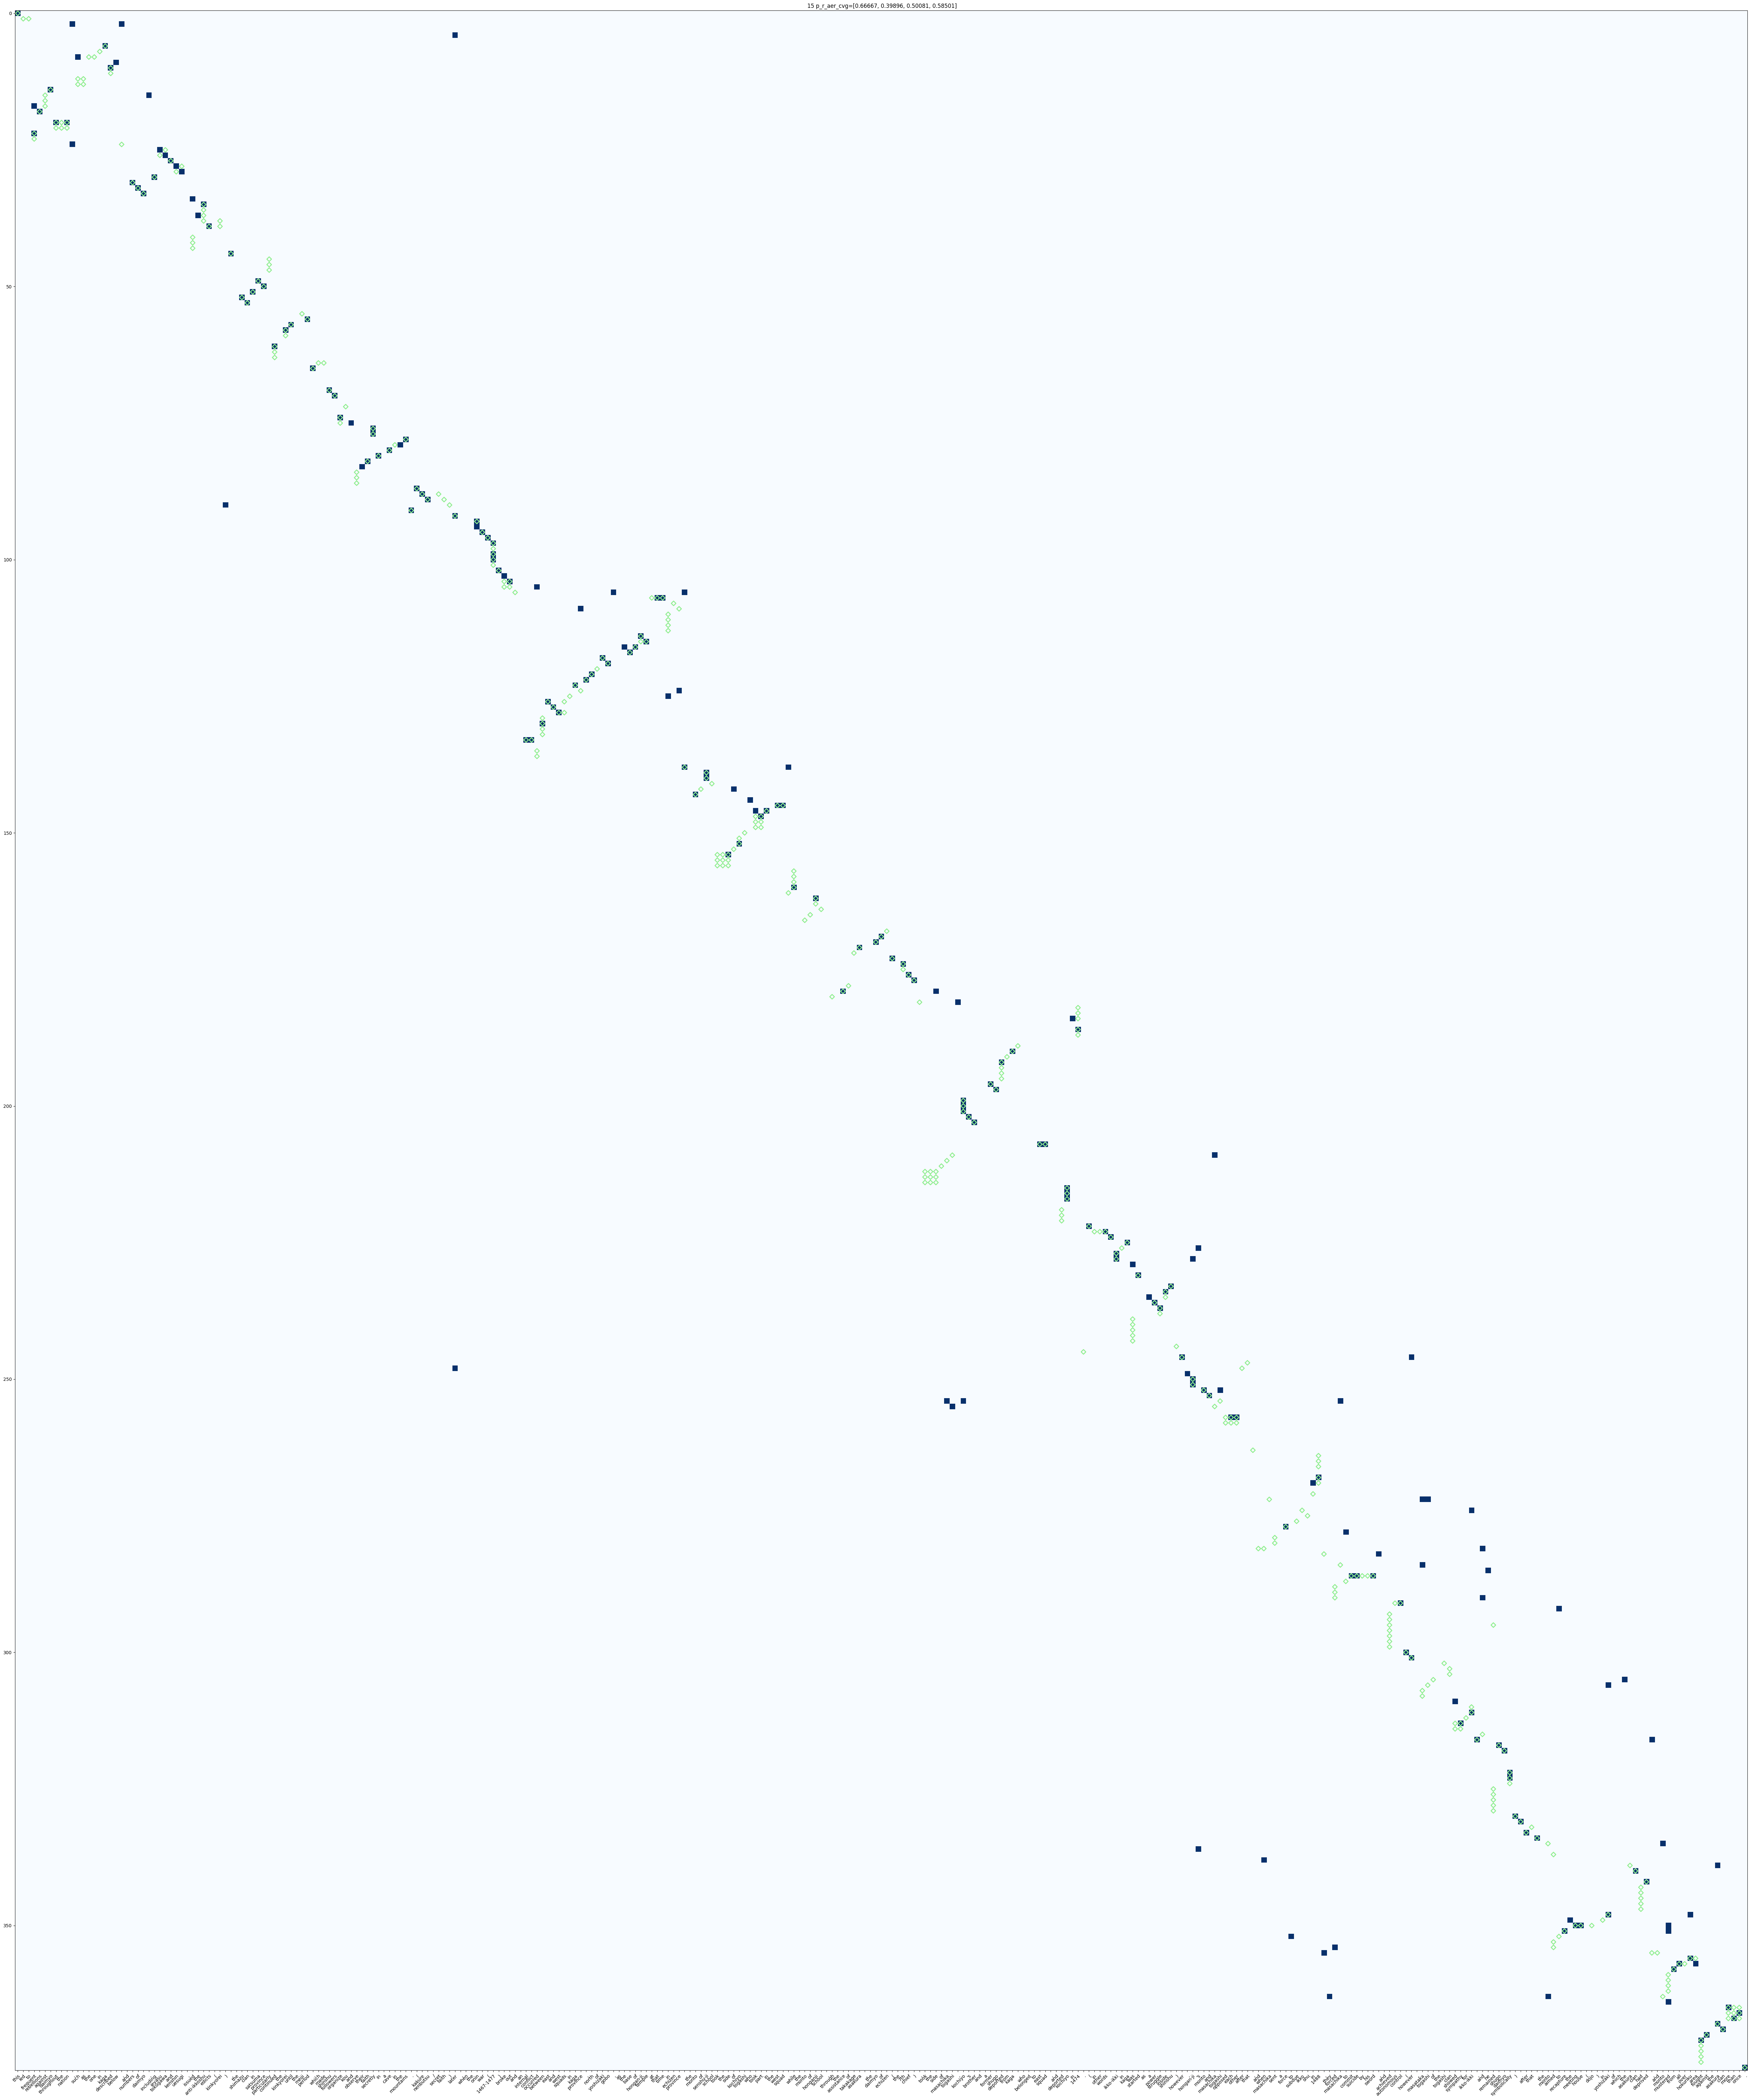

In [128]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
def display_alignment(index, sure, possible, word_alignment, source, target, language, bigger_boxes=False):
    m = len(source)
    l = len(target)
    hypothesis_mat = np.zeros((m, l))
    hypothesis_mat[tuple(zip(*word_alignment))] = 1
    # plt.style.use('_mpl-gallery-nogrid')
    multiplier = 1 if bigger_boxes else 0.5 
    multiplier = 0.2 # smaller boxes for wandb
    fig, ax = plt.subplots(figsize = (1 + len(source) * multiplier, 1 + len(target) * multiplier))
    # precision recall for this image:
    
    num_sure = len(sure)
    guesses_made = len(word_alignment)
    guesses_made_in_sure = len(set(word_alignment).intersection(sure))
    guesses_made_in_possible = len(set(word_alignment).intersection(possible))
    precision = guesses_made_in_possible / guesses_made
    recall = guesses_made_in_sure / num_sure
    aer = 1 - ((guesses_made_in_possible + guesses_made_in_sure) / (guesses_made + num_sure))
    
    num_words_total = m + l
    num_words_covered = len(set(s for s,t in word_alignment)) + len(set(t for s,t in word_alignment))
    coverage = num_words_covered / num_words_total

    ax.set_title(f"{index:3} p_r_aer_cvg=[{precision:.5f}, {recall:.5f}, {aer:.5f}, {coverage:.5f}]")
    im = ax.imshow(hypothesis_mat, cmap='Blues', vmin=0, vmax=1)
    ax.set_xticks(np.arange(len(target)), labels=target)
    
    if 'jaen' not in (language or " "):
        ax.set_yticks(np.arange(len(source)), labels=source)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    # for i in range(m): # this will be useful when I want to plot percentages maybe when doing something more than word alignment.
    #     for j in range(l):
    #         text = ax.text(j, i, hypothesis_mat[i, j],
    #                     ha="center", va="center", color="orange")
    patches_sure = []
    patches_possible = []
    for box in sure:
        patches_sure.append(Rectangle((box[1]-0.3,box[0]-0.3), 0.6, 0.6, angle=45, rotation_point="center"))
    for box in set(possible).difference(set(sure)):
        patches_possible.append(Rectangle((box[1]-0.4,box[0]-0.4), 0.8, 0.8))
    ax.add_collection(PatchCollection(patches_sure, edgecolor="LightGreen", facecolor="none",lw=2))
    ax.add_collection(PatchCollection(patches_possible, edgecolor="Orange", facecolor="none", lw=2))
    # ax.legend(["Orange is possible", "Green is sure"]) # this doesn't seem to work, but only necessary for paper, and can be added in post.
    fig.tight_layout()
    # print(df.sort_values(out_format + 'impact_on_aer').index.tolist()[::-1])
    return fig 
display_alignment(first_lines, gold_sure_word_alignments, gold_sure_word_alignments, word_alignments, src.split(), tgt.split(), language="jaen");

In [129]:
len(src.split()), len(tgt.split())

(377, 317)

In [2]:
# timing the forward pass of bert does about 33 % slower for running the rest of the model.
from transformers import BertForMaskedLM as HFBertForMaskedLM
# from transformers.models.bert import BertForMaskedLM
import torch
import timeit
import time
model_name = "google-bert/bert-base-multilingual-cased"
device = "cuda"
model_hf_base: HFBertForMaskedLM = HFBertForMaskedLM.from_pretrained(model_name, ignore_mismatched_sizes=True).to(device) # type: ignore

input_dummy_data = torch.randint(0, 2000, (32, 512,), device=device)
# def do_stuff():

# def hook(m, i, o=None):
#     print(time.time())

# handles = []
# handles.append(model_hf_base.bert.register_forward_pre_hook(hook))
# handles.append(model_hf_base.bert.encoder.layer[7].register_forward_hook(hook))
# handles.append(model_hf_base.cls.register_forward_hook(hook))

model_hf_base(input_ids=input_dummy_data, attention_mask=(input_dummy_data != 0))
# [handle.remove() for handle in handles];
# now concat all the tokens from de together, and see how long it would take to encode them all?
# timeit.timeit(do_stuff, number=100)

Some weights of the model checkpoint at google-bert/bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1722548343.9515126
1722548343.9566543
1722548343.958581


MaskedLMOutput(loss=None, logits=tensor([[[-4.6589, -5.5733, -5.0571,  ..., -2.5611, -4.1598, -3.7215],
         [-4.4789, -4.5963, -5.2480,  ..., -4.4263, -3.7023, -4.2727],
         [-2.8390, -2.4960, -3.3355,  ..., -2.2080, -2.6400, -2.1785],
         ...,
         [-2.3649, -2.0738, -3.1991,  ..., -2.3906, -2.7330, -3.2125],
         [-2.8385, -2.2529, -3.7589,  ..., -3.2625, -2.5879, -3.3829],
         [-2.6641, -2.1425, -3.1769,  ..., -2.0050, -2.5285, -1.9412]],

        [[-4.4542, -5.5395, -4.8387,  ..., -2.4475, -3.5657, -3.4549],
         [-5.1428, -5.3833, -5.2248,  ..., -4.9785, -4.7400, -4.5160],
         [-4.5501, -4.4916, -4.8488,  ..., -3.8000, -3.8501, -2.8966],
         ...,
         [-3.3131, -2.8441, -3.8255,  ..., -1.4054, -4.4343, -3.3747],
         [-3.0288, -2.9953, -3.7495,  ..., -2.6490, -2.8021, -2.4366],
         [-5.1453, -5.1889, -5.7169,  ..., -4.5150, -4.7422, -4.8650]],

        [[-4.0708, -5.0657, -4.5067,  ..., -1.9892, -3.5914, -3.0723],
         [-4

In [9]:
# 39.1081/100

0.291081

In [2]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from glob import glob
import tqdm

In [3]:
# import matplotlib
# matplotlib.font_manager._rebuild()
# from matplotlib import font_manager
# "Cascadia Code"
# rc("font", family="LiberationSans")
# font_manager.findSystemFonts()
# matplotlib.rc('font', family=font_manager.get_font("/nethome/jbjorner3/.fonts/TakaoPGothic.ttf"))

gold
(1.0, 1.0, 0.0, 0.8675156441220794)
['明治', '5', '年', '（', '1872', '年', '）', '太政官', '正院', 'から', '各', '府県', 'へ', '「', '一向', '宗', '名', '之', '儀', '、', '自今', '真宗', 'ト', '改名', '可致', '旨', '」', 'の', '布告', 'が', '発', 'せ', 'られ', '、', 'ここ', 'に', '近代', 'に', 'な', 'っ', 'て', 'ようやく', '「', '（', '浄土', '）', '真宗', '」', 'と', '表記', 'する', 'こと', 'が', '認め', 'られ', 'た', 'の', 'で', 'あ', 'る', '。']
['in', '1872', ',', 'dajokan', 'seiin', 'issued', 'an', 'edict', 'to', 'each', 'prefecture', ',', 'saying', '"', 'the', 'name', 'of', 'ikko', 'shu', 'can', 'be', 'changed', 'to', 'shinshu', ',', '"', 'and', 'finally', 'here', 'in', 'the', 'modern', 'ages', ',', 'describing', 'it', 'as', '"', '(', 'jodo', ')', 'shinshu', '"', 'was', 'allowed', '.']
明治 5 年 （ 1872 年 ） 太政官 正院 から 各 府県 へ 「 一向 宗 名 之 儀 、 自今 真宗 ト 改名 可致 旨 」 の 布告 が 発 せ られ 、 ここ に 近代 に な っ て ようやく 「 （ 浄土 ） 真宗 」 と 表記 する こと が 認め られ た の で あ る 。
in 1872 , dajokan seiin issued an edict to each prefecture , saying " the name of ikko shu can be changed to shinshu , " and 

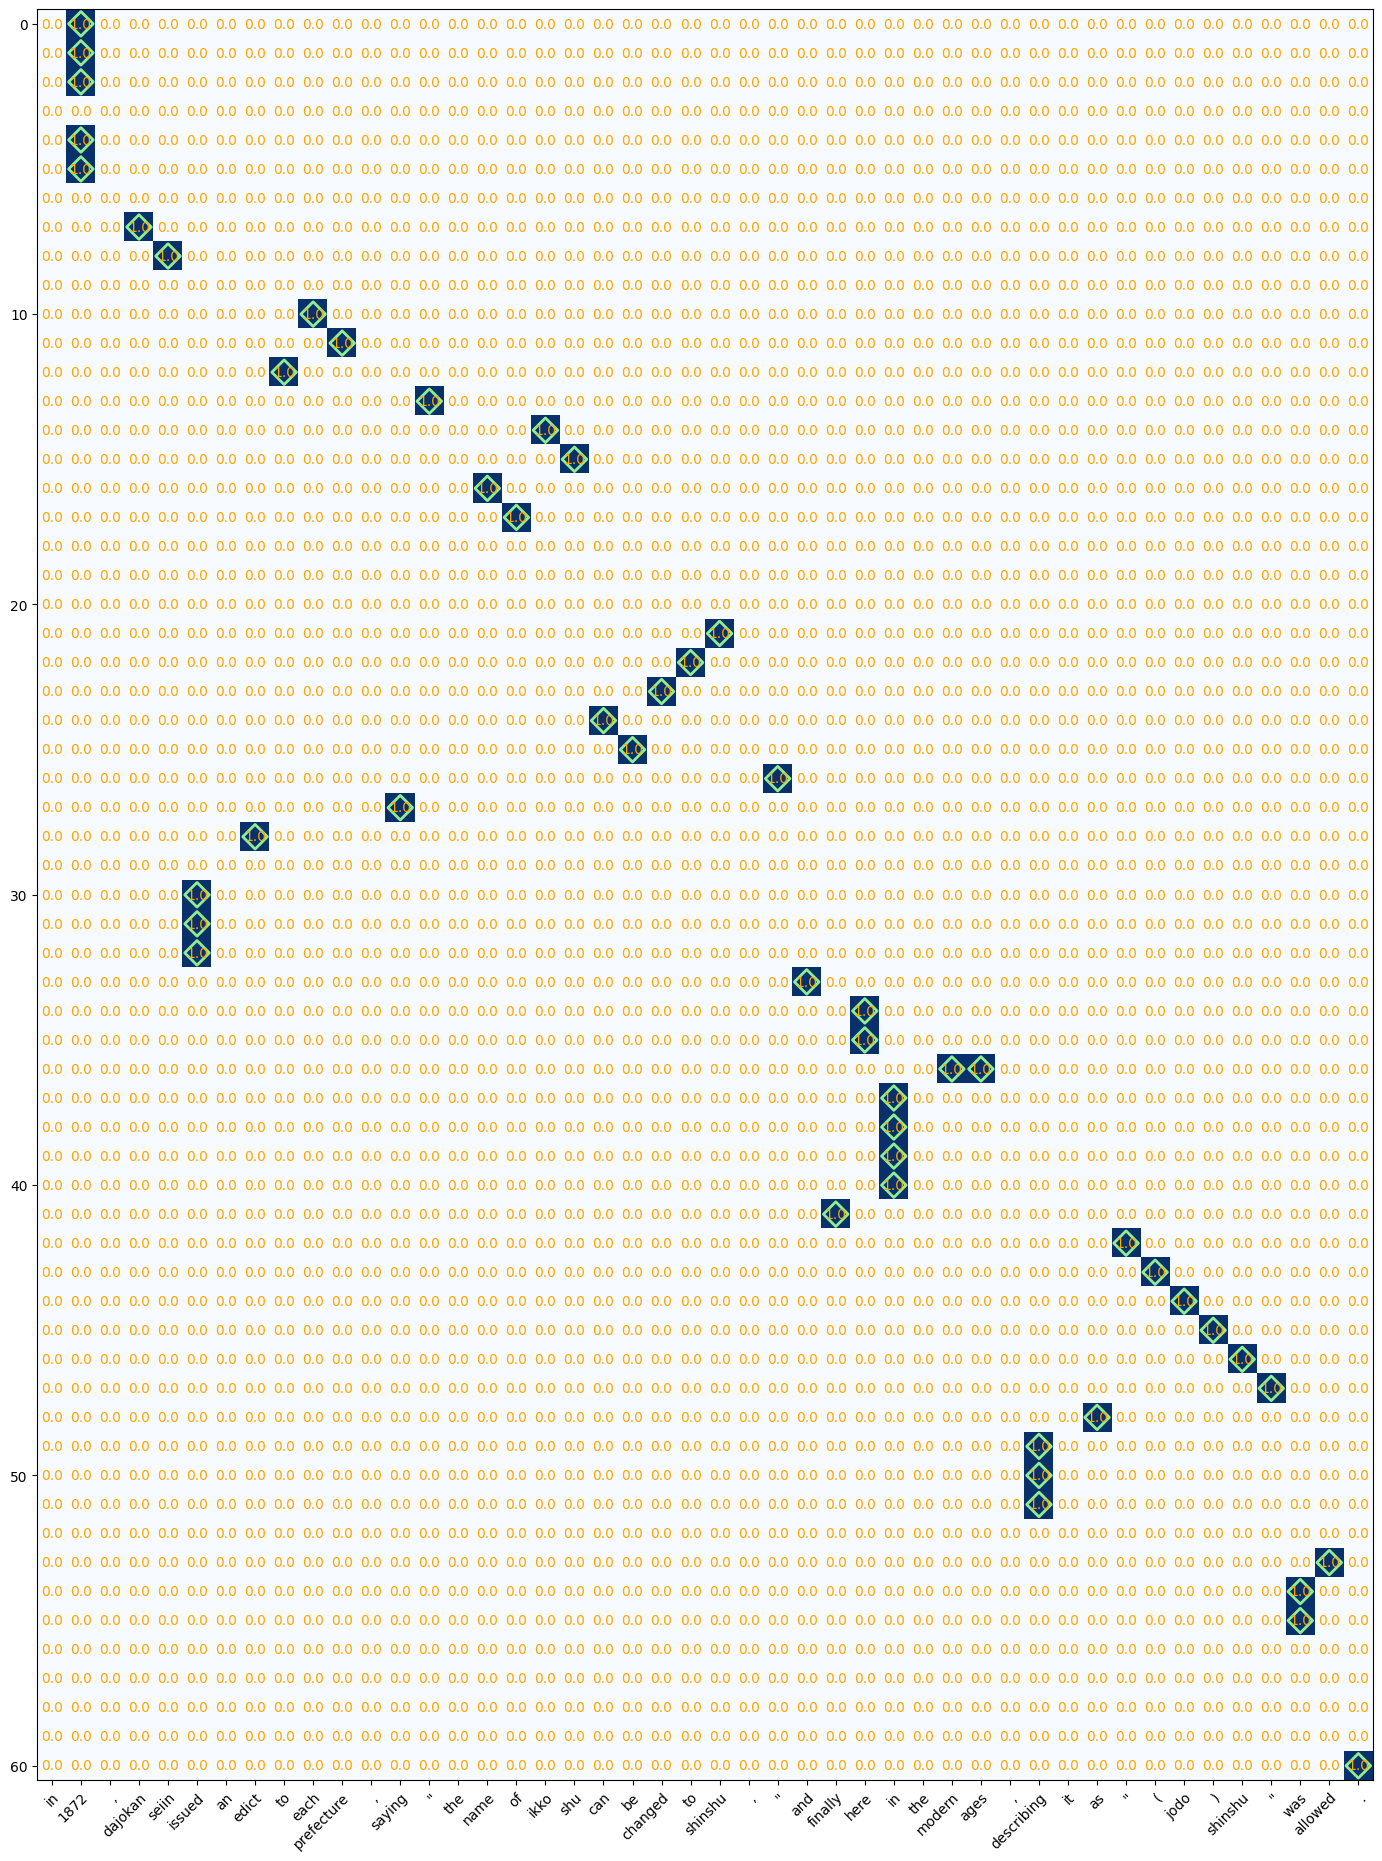

[99, 36, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 98, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 25, 24, 23, 22, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 48, 49, 50, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 76, 74, 51, 73, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 0]


In [4]:
langset= "jaen_eval_first100"
paths = glob(f"../data/awesome_eval_data/{langset}.*")
# print(paths)
df = pd.DataFrame({path.split(f'/')[-1].replace(f"{langset}.", ""): open(path, "r", encoding='utf-8').read().split('\n')[:-1] for path in paths})
# datum = df.iloc[130] # ["nofinetune.out"]
def prepare_raw_datum(raw_gold, raw_hypothesis, raw_srt_tgt):
    src, tgt = [d.strip().split(" ") for d in raw_srt_tgt.split(" ||| ")]
    m = len(src)
    l = len(tgt)
    gold_mat = np.zeros((m, l)) # assume gold is 1 indexed, so subtract by 1.
    sub = 1
    if "jaen" in langset and "awesome_test_examples" not in paths[0]:
        sub = 0
    possible_gold_mat = [tuple(int(i)-sub for i in out.replace('-', 'p').split('p')) for out in raw_gold.strip().split(' ')]
    sure_gold_mat = [tuple(int(i)-sub for i in out.split('-')) for out in raw_gold.strip().split(' ') if "-" in out]
    gold_mat[tuple(zip(*possible_gold_mat))] = 0.5
    gold_mat[tuple(zip(*sure_gold_mat))] = 1

    out_mat = np.zeros((m, l))
    sure_hypo_mat = [tuple(int(i)-sub for i in out.split('-')) for out in raw_hypothesis.split(' ') if "-" in out]
    out_mat[tuple(zip(*sure_hypo_mat))] = 1

    return gold_mat, out_mat, src, tgt
def get_prec_recall_aer(sure, possible, hypothesis, srcs, tgts, return_impact=False):
    total_sure = 0
    total_guessed = 0
    # recall is the ones you can get right out of the ones there are to get right.
    # this is the A intersect sure / sure
    total_recall_numerator = 0

    # precision is the ones you get right out of the ones you guessed.
    # this is A interect possible / A
    total_precision_numerator = 0
    coverages = []

    for s, p, h in zip(sure, possible, hypothesis):
        total_sure += len(s)
        total_guessed += len(h)
        total_recall_numerator += len(set(s).intersection(h))
        total_precision_numerator += len(set(h).intersection(p))
    precision = total_precision_numerator / total_guessed
    recall = total_recall_numerator / total_sure
    aer = 1 - (total_recall_numerator + total_precision_numerator) / (total_sure + total_guessed)

    num_sure = 0
    guesses_made = 0
    guesses_made_in_possible = 0
    guesses_made_in_sure = 0

    # num_words_total = 0
    # num_words_covered = 0
    coverages = []
    for gold_sure_word_alignment, gold_possible_word_alignment, word_level_alignment, src, tgt in zip(sure, possible, hypothesis, srcs, tgts):
    
        num_sure += len(gold_sure_word_alignment)
        guesses_made += len(word_level_alignment)
        guesses_made_in_sure += len(set(word_level_alignment).intersection(gold_sure_word_alignment))
        guesses_made_in_possible += len(set(word_level_alignment).intersection(gold_possible_word_alignment))
        # num_words_total += len(src) + len(tgt) # this doesn't account for the fact we only take the first 510 tokens to align.
        # num_words_covered += len(set(s for s,t in word_level_alignment)) + len(set(t for s,t in word_level_alignment))
        coverages.append((len(set(s for s,t in word_level_alignment)) + len(set(t for s,t in word_level_alignment))) / (len(src) + len(tgt)))
    precision2 = guesses_made_in_possible / guesses_made
    recall2 = guesses_made_in_sure / num_sure
    aer2 = 1 - ((guesses_made_in_possible + guesses_made_in_sure) / (guesses_made + num_sure))
    coverage = sum(coverages) / len(coverages)
    assert (precision == precision2)
    assert (recall == recall2)
    assert (aer == aer2)

    if return_impact:
        impact = (total_sure + total_guessed) - (total_recall_numerator + total_precision_numerator)
        return precision2, recall2, aer2, coverage, impact
    else:
        return precision2, recall2, aer2, coverage

# display_alignment(*prepare_raw_datum(datum["gold"], datum['nofinetune.out'], datum['src-tgt']))

for out_format in ["gold"]: # , "fast-grow-diagonal"
    sure = []
    possible = []
    hypothesis = []
    srcs = []
    tgts = []
    for i in range(len(df)):
        datum = df.iloc[i]
        gold_mat, out_mat, src, tgt = prepare_raw_datum(datum["gold"], datum["gold"], datum['src-tgt'])
        
        s = list(zip(*np.where(gold_mat==1)))
        p = list(zip(*np.where(gold_mat>=0.5)))
        h = list(zip(*np.where(out_mat==1)))
        df.loc[i,out_format + "precision"], df.loc[i,out_format + "recall"], df.loc[i,out_format + "aer"], df.loc[i,out_format + "coverage"], df.loc[i, out_format + "impact_on_aer"] = get_prec_recall_aer([s], [p], [h], [src], [tgt], return_impact=True) # type: ignore
        
        sure.append(s)
        possible.append(p)
        hypothesis.append(h)
        srcs.append(src)
        tgts.append(tgt)
    print(out_format)
    print(get_prec_recall_aer(sure, possible, hypothesis, srcs, tgts))
def display_alignment(gold, hypothesis, source, target, p_r_aer=None, bigger_boxes=False, matrix_to_compute_p_r_aer=None, language=None):
    m = len(source)
    l = len(target)
    # plt.style.use('_mpl-gallery-nogrid')
    multiplier = 1 if bigger_boxes else 0.5 
    fig, ax = plt.subplots(figsize = (len(source) * multiplier, len(target) * multiplier))
    im = ax.imshow(hypothesis, cmap='Blues')
    ax.set_xticks(np.arange(len(target)), labels=target)
    
    if 'jaen' not in (language or " "):
        ax.set_yticks(np.arange(len(source)), labels=source)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(m):
        for j in range(l):
            text = ax.text(j, i, hypothesis[i, j],
                        ha="center", va="center", color="orange")
    patches_sure = []
    patches_possible = []
    for box in zip(*np.where(gold == 1.)):
        patches_sure.append(Rectangle((box[1]-0.3,box[0]-0.3), 0.6, 0.6, angle=45, rotation_point="center"))
    for box in zip(*np.where(gold == 0.5)):
        patches_possible.append(Rectangle((box[1]-0.4,box[0]-0.4), 0.8, 0.8))
    ax.add_collection(PatchCollection(patches_sure, edgecolor="LightGreen", facecolor="none",lw=2))
    ax.add_collection(PatchCollection(patches_possible, edgecolor="Orange", facecolor="none", lw=2))
    # fig.tight_layout()

    print(source)
    print(target)
    print(' '.join(source))
    print(' '.join(target))
    if p_r_aer:
        print(p_r_aer)
    elif matrix_to_compute_p_r_aer is not None:
        sure = [list(zip(*np.where(gold==1)))]
        possible = [list(zip(*np.where(gold>=0.5)))]
        hypothesis = [list(zip(*np.where(matrix_to_compute_p_r_aer==1)))]

        print(get_prec_recall_aer(sure, possible, hypothesis, [source], [target]))
    print("orange boxes indicate possible alignments, and green diamonds indicate sure alignments as labeled by human annotators")
    plt.show()
    print(df.sort_values(out_format + 'impact_on_aer').index.tolist()[::-1])
for i in [99]:
    datum = df.iloc[i]
    out_format = 'gold'
    display_alignment(*prepare_raw_datum(datum["gold"], datum[f'gold'], datum['src-tgt']), (df.loc[i,out_format + "precision"], df.loc[i, out_format + "recall"], df.loc[i, out_format + "aer"]), language=langset)

In [25]:
from greek.dataset.dataset import AwesomeAlignDataset
enfr_eval_dataset = AwesomeAlignDataset(tokenizer, "../data/awesome_eval_data/enfr_eval_first100.src-tgt", "../data/awesome_eval_data/enfr_eval_first100.gold", gold_one_index=True, ignore_possible_alignments=False)

In [26]:
enfr_eval_dataset

In [19]:
# jaen_eval_past100: 0.7896173224568138

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw